In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import numpy as np
from joblib import Parallel, delayed

# Step 1: Read the CSV File
data = pd.read_csv('/content/encoded_resampled_dataset.csv')  # Update the file path

# Step 2: Separate Features and Targets
X = data.drop(columns=['clarity', 'color', 'cut'])  # Features
Y = data[['clarity', 'color', 'cut']]  # Multi-label targets

# Step 3: Convert Multi-Label Targets to Multi-Class
Y = Y.values.argmax(axis=1)  # Convert to single-label multi-class by argmax

# Step 4: Split Data into Training, Validation, and Test Sets (Stratified Split)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=42)

# Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 6: Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 7: Set up Gradient Boosting Classifier and Hyperparameter Grid
gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 150],  # Reduced range
    'learning_rate': [0.05, 0.1],  # Reduced range
    'max_depth': [3, 5],
    'subsample': [0.8],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Step 8: Hyperparameter Tuning using RandomizedSearchCV (with fewer iterations)
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_grid, n_iter=30, cv=3, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train_pca, Y_train)

# Step 9: Best Parameters after RandomizedSearchCV
best_gb_model = random_search.best_estimator_

# Step 10: Train the Model using Best Parameters
best_gb_model.fit(X_train_pca, Y_train)

# Step 11: Predictions on Validation and Test Set
Y_train_pred = best_gb_model.predict(X_train_pca)
Y_val_pred = best_gb_model.predict(X_val_pca)
Y_test_pred = best_gb_model.predict(X_test_pca)

# Step 12: Calculate Precision, Recall, Accuracy, F1 Score for all datasets
def compute_metrics(y_true, y_pred):
    return {
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred, average='weighted')
    }

metrics_train = compute_metrics(Y_train, Y_train_pred)
metrics_val = compute_metrics(Y_val, Y_val_pred)
metrics_test = compute_metrics(Y_test, Y_test_pred)

# Step 13: Print the metrics for train, validation, and test sets
print(f"Train Precision: {metrics_train['precision']:.4f}, Recall: {metrics_train['recall']:.4f}, Accuracy: {metrics_train['accuracy']:.4f}, F1 Score: {metrics_train['f1_score']:.4f}")
print(f"Validation Precision: {metrics_val['precision']:.4f}, Recall: {metrics_val['recall']:.4f}, Accuracy: {metrics_val['accuracy']:.4f}, F1 Score: {metrics_val['f1_score']:.4f}")
print(f"Test Precision: {metrics_test['precision']:.4f}, Recall: {metrics_test['recall']:.4f}, Accuracy: {metrics_test['accuracy']:.4f}, F1 Score: {metrics_test['f1_score']:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Train Precision: 0.9819, Recall: 0.9827, Accuracy: 0.9827, F1 Score: 0.9811
Validation Precision: 0.9788, Recall: 0.9803, Accuracy: 0.9803, F1 Score: 0.9784
Test Precision: 0.9779, Recall: 0.9796, Accuracy: 0.9796, F1 Score: 0.9777


In [10]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Function to calculate and print the metrics for a dataset (Train, Validation, Test)
def print_metrics(y_true, y_pred, dataset_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"{dataset_name} Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("-" * 30)

# Train metrics
print_metrics(Y_train, Y_train_pred, "Train")

# Validation metrics
print_metrics(Y_val, Y_val_pred, "Validation")

# Test metrics
print_metrics(Y_test, Y_test_pred, "Test")


Train Metrics:
  Precision: 0.9819
  Recall: 0.9827
  Accuracy: 0.9827
  F1 Score: 0.9811
------------------------------
Validation Metrics:
  Precision: 0.9788
  Recall: 0.9803
  Accuracy: 0.9803
  F1 Score: 0.9784
------------------------------
Test Metrics:
  Precision: 0.9779
  Recall: 0.9796
  Accuracy: 0.9796
  F1 Score: 0.9777
------------------------------


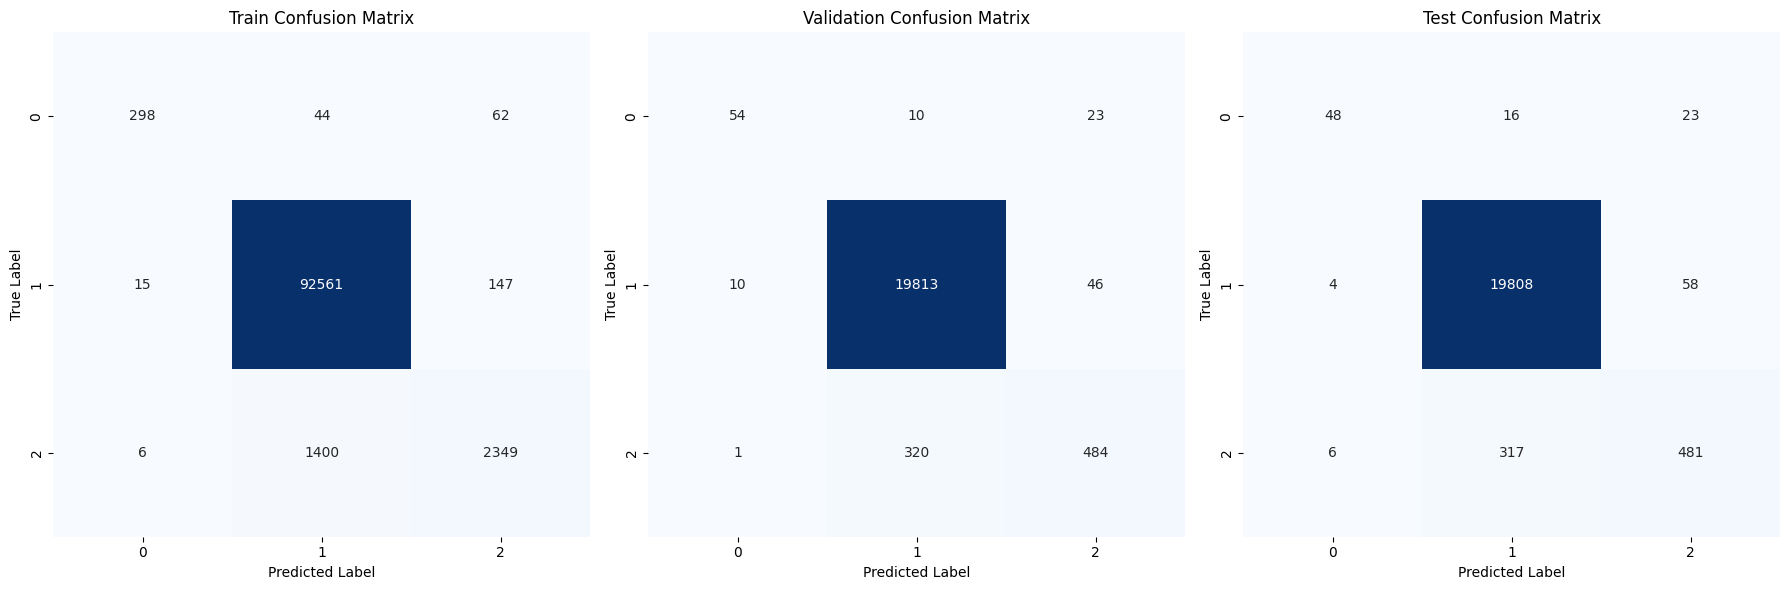

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Step 1: Compute the confusion matrix for the predictions
conf_matrix_train = confusion_matrix(Y_train, Y_train_pred)
conf_matrix_val = confusion_matrix(Y_val, Y_val_pred)
conf_matrix_test = confusion_matrix(Y_test, Y_test_pred)

# Step 2: Create a function to plot the confusion matrix
def plot_confusion_matrix(conf_matrix, ax, title='Confusion Matrix'):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(Y), yticklabels=np.unique(Y), ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Step 3: Create a single figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Step 4: Plot confusion matrices for Train, Validation, and Test sets side by side
plot_confusion_matrix(conf_matrix_train, axes[0], title="Train Confusion Matrix")
plot_confusion_matrix(conf_matrix_val, axes[1], title="Validation Confusion Matrix")
plot_confusion_matrix(conf_matrix_test, axes[2], title="Test Confusion Matrix")

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


Y_train shape: (96882,)
Y_val shape: (20761,)
Y_test shape: (20761,)
Y_train_prob shape: (96882, 3)
Y_val_prob shape: (20761, 3)
Y_test_prob shape: (20761, 3)


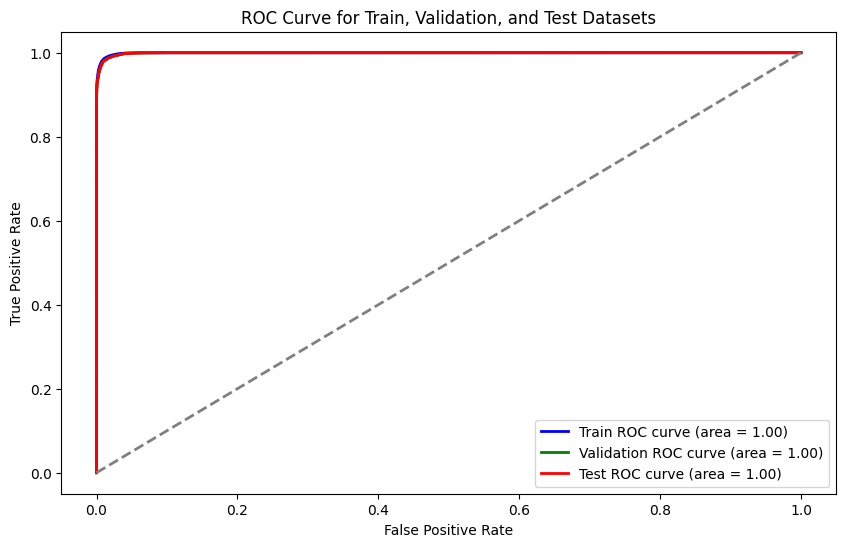

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Check the shape of Y_train, Y_val, Y_test, and predicted probabilities
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_val shape: {Y_val.shape}')
print(f'Y_test shape: {Y_test.shape}')
print(f'Y_train_prob shape: {Y_train_prob.shape}')
print(f'Y_val_prob shape: {Y_val_prob.shape}')
print(f'Y_test_prob shape: {Y_test_prob.shape}')

# Step 1: Binarize the labels for multi-class ROC (if necessary)
Y_train_bin = label_binarize(Y_train, classes=np.unique(Y))
Y_val_bin = label_binarize(Y_val, classes=np.unique(Y))
Y_test_bin = label_binarize(Y_test, classes=np.unique(Y))

# Step 2: Ensure the predicted probabilities for each class are of correct shape
# For binary classification, we use the second column of the probabilities
if Y_train_bin.shape[1] == 2:  # Binary classification
    Y_train_prob = best_gb_model.predict_proba(X_train_pca)[:, 1]
    Y_val_prob = best_gb_model.predict_proba(X_val_pca)[:, 1]
    Y_test_prob = best_gb_model.predict_proba(X_test_pca)[:, 1]
else:  # Multi-class classification
    Y_train_prob = best_gb_model.predict_proba(X_train_pca)
    Y_val_prob = best_gb_model.predict_proba(X_val_pca)
    Y_test_prob = best_gb_model.predict_proba(X_test_pca)

# Step 3: Compute ROC curve and AUC for each dataset
fpr_train, tpr_train, _ = roc_curve(Y_train_bin.ravel(), Y_train_prob.ravel())
fpr_val, tpr_val, _ = roc_curve(Y_val_bin.ravel(), Y_val_prob.ravel())
fpr_test, tpr_test, _ = roc_curve(Y_test_bin.ravel(), Y_test_prob.ravel())

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)
roc_auc_test = auc(fpr_test, tpr_test)

# Step 4: Plot the ROC curves for Train, Validation, and Test datasets
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_val, tpr_val, color='green', lw=2, label=f'Validation ROC curve (area = {roc_auc_val:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')

# Step 5: Plot the diagonal line for random classifier (45-degree line)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Step 6: Customize the plot
plt.title('ROC Curve for Train, Validation, and Test Datasets')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Step 7: Display the plot
plt.show()
